<h1>Theanoによる回帰分析</h1>

In [120]:
%matplotlib inline
import theano.tensor as T
import numpy as np
import theano
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

<h2>人口データの作成</h2>

<h3>各種セッティング</h3>

In [271]:
N = 1000   #データ数
true_coef = np.array([2., 3., 12. , 5. , 4.], dtype = np.float32)
A_shape = len(true_coef)
test_size = 0.3
idx = np.arange(N)
train_idx = idx[:int(N*(1-test_size))]
test_idx = idx[int(N*test_size): ]

<h3>データの生成</h3>

In [272]:
X_data = np.c_[np.ones(N), np.random.randn(N,4)]
X_data = X_data.astype(np.float32)
z_data = np.random.randn(N)
z_data = z_data.astype(np.float32)
y_data = X_data.dot(true_coef) + z_data

<h3>学習データとテストデータの分割</h3>

In [273]:
X_data, y_data  = shuffle(X_data, y_data)
X_train = X_data[train_idx]
y_train = y_data[train_idx]
X_test = X_data[test_idx]
y_test = y_data[test_idx]

<h2>Theanoによる計算式作成</h2>

<h3> 必要な入れ物と更新式の用意</h3>
<p> 回帰分析のモデルは、$y  = XA + \epsilon (Xは(n, m)の行列, Aはmのベクトル）$　で、目的関数: $\Sigma(y_{実際} - y_{推定})^2$　を最小化します。
そこで必要な入れ物は、XとYとAです。XとYはデータで、学習過程でAを調整して目的関数が最小になるようにしていきます。
Theanoでは、アップデートしていく変数をsharedで定義し、データとして与える入れ物はtheano.tensor（ここではTという名前）で定義します。</p>

In [290]:
X = T.matrix('X', dtype = 'float32')
y = T.vector('y', dtype = 'float32')
A = theano.shared(np.random.randn(A_shape))
dA = theano.shared(np.zeros(A_shape, dtype=np.float32), 'dA')
#decay_step = theano.shared(np.float32(1.0), 'decay_step' )

<p>素直に上の式でモデルと目的関数を定義すると以下のようになります</p>

In [291]:
y_hat = X.dot(A)
cost = ((y - y_hat)**2).sum()

<p>パラメータであるAをどのように更新するかというとGradient Descent(勾配法）で更新していきます。勾配法では、目的関数をパラメータで微分しないといけないのですが、Theanoには、gradという自動で微分をしてくれる機能がありますので、それを使うと簡単にかけます。$lr$はLearning Rate（学習率）でどのくらい更新していくかを決めるものです。</p>

In [292]:
lr = 1e-7
mu = 0.01
#update_A = A - lr*T.grad(cost, A)
update_A = A + mu * dA -  lr*T.grad(cost, A)
#update_A = A + mu * dA -  (lr*1.0/decay_step) * T.grad(cost, A)


<h3>実際に学習していくための関数を作成</h3>
<p>theano.functionという関数を使って学習するための関数を作ります。データとして与えるインプット、更新する対象の変数を定義します。さらに、ちゃんと学習過程で目的関数が小さくなっていくのかを見るためにget_predicttion関数を作ります</p>

In [294]:
train = theano.function(inputs = [X, y],
                   updates = [(A, update_A),
                             #(decay_step, decay_step+np.float32(0.1))
                             ])

get_prediction = theano.function(
        inputs=[X, y],
        outputs=[cost, y_hat],
    )

<h3>さあ、いよいよ学習です</h3>

<p>どのくらい学習させるのかと同時に目的関数の出力値の出力間隔を決めます</p>

In [295]:
epochs = 3000
print_period= 100

<p>MSEを計算する関数も作っておきましょう</p>

In [296]:
def get_mse(y_pred, y_true):
    return sum((y_pred - y_true)**2)/len(y_pred)

<p>それでは学習です</p>

In [297]:
cost_history = []
decay_step = 0
for i in xrange(epochs):
    train(X_train, y_train)
    if i % print_period == 0:
        cost_val, prediction_val = get_prediction(X_test, y_test)
        err = get_mse(prediction_val, y_test)
        print "Cost at iteration i=%d : %.3f / %.3f" % (i, cost_val, err)
        cost_history.append(cost_val)

Cost at iteration i=0 : 119893.466 / 171.276
Cost at iteration i=100 : 116970.496 / 167.101
Cost at iteration i=200 : 114119.904 / 163.028
Cost at iteration i=300 : 111339.877 / 159.057
Cost at iteration i=400 : 108628.648 / 155.184
Cost at iteration i=500 : 105984.497 / 151.406
Cost at iteration i=600 : 103405.745 / 147.722
Cost at iteration i=700 : 100890.756 / 144.130
Cost at iteration i=800 : 98437.936 / 140.626
Cost at iteration i=900 : 96045.732 / 137.208
Cost at iteration i=1000 : 93712.629 / 133.875
Cost at iteration i=1100 : 91437.151 / 130.625
Cost at iteration i=1200 : 89217.858 / 127.454
Cost at iteration i=1300 : 87053.350 / 124.362
Cost at iteration i=1400 : 84942.258 / 121.346
Cost at iteration i=1500 : 82883.249 / 118.405
Cost at iteration i=1600 : 80875.026 / 115.536
Cost at iteration i=1700 : 78916.322 / 112.738
Cost at iteration i=1800 : 77005.903 / 110.008
Cost at iteration i=1900 : 75142.565 / 107.347
Cost at iteration i=2000 : 73325.137 / 104.750
Cost at iteration

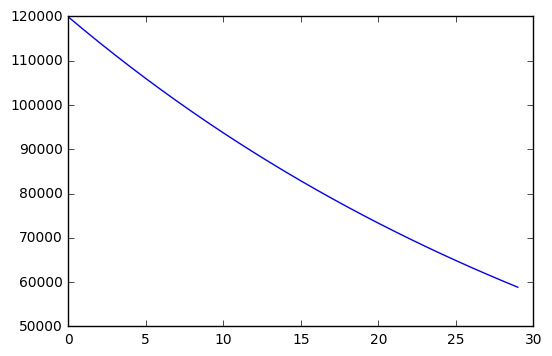

In [298]:
plt.plot(cost_history)

In [299]:
A.get_value()

array([ 0.00517866,  0.70440381,  5.16063607,  0.45998349,  0.76195356])